# Bayesian computations with Neural Networks

Neural network training is typically done with maximum likelihood estimation. Given the number of parameter invariances in neural network architectures, this often introduces a large number of local minima, making global optimisation very difficult.

JAXNS can easily compute the evidence and posterior of a neural network. The larger number of parameters means that we should be careful with how accurate we want this to be. With high precision, we'll need more likelihood evaluations

## Overview

In this tutorial we'll cover:
1. How to build a JAXNS model of a neural network using [Haiku](https://github.com/deepmind/dm-haiku)
2. How to do posterior and evidence estimation with JAXNS

In [1]:
try:
    import haiku as hk
except ImportError:
    print("You must `pip install dm-haiku` first.")

from jax.config import config

config.update("jax_enable_x64", True)


from jax import numpy as jnp, random, vmap, jit
import jax
from jax.flatten_util import ravel_pytree

from jaxns import PriorChain, UniformPrior
from jaxns import NestedSampler, resample
from jaxns import plot_diagnostics
from itertools import product

import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=6"



In [2]:
# Generate data

def xor_reduce(x):
    """
    Computes the XOR reduction on a sequence of bits.

    Examples:
        100 -> xor(xor(1,0),0) = 1
        001 -> xor(xor(0,0),1) = 1
        110 -> xor(xor(1,1),0) = 0
        011 -> xor(xor(0,1),1) = 0

    Args:
        x: boolean vector of bits.

    Returns:
        bool, scalar
    """
    output = x[0]
    for i in range(1, x.shape[-1]):
        output = jnp.logical_xor(output, x[i])
    return output


num_variables = 7
options = [True, False]
x = jnp.asarray(list(product(options, repeat=num_variables)))#N,2
y = vmap(xor_reduce)(x)[:, None]#N, 1
x = x.astype(jnp.float32)
print("Data:")

for input, output in zip(x,y):
    print(f"{input} -> {output}")


INFO[2022-05-30 12:41:09,060]: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO[2022-05-30 12:41:09,061]: Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
INFO[2022-05-30 12:41:09,062]: Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
WARNING[2022-05-30 12:41:09,062]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Data:
[1. 1. 1. 1. 1. 1. 1.] -> [ True]
[1. 1. 1. 1. 1. 1. 0.] -> [False]
[1. 1. 1. 1. 1. 0. 1.] -> [False]
[1. 1. 1. 1. 1. 0. 0.] -> [ True]
[1. 1. 1. 1. 0. 1. 1.] -> [False]
[1. 1. 1. 1. 0. 1. 0.] -> [ True]
[1. 1. 1. 1. 0. 0. 1.] -> [ True]
[1. 1. 1. 1. 0. 0. 0.] -> [False]
[1. 1. 1. 0. 1. 1. 1.] -> [False]
[1. 1. 1. 0. 1. 1. 0.] -> [ True]
[1. 1. 1. 0. 1. 0. 1.] -> [ True]
[1. 1. 1. 0. 1. 0. 0.] -> [False]
[1. 1. 1. 0. 0. 1. 1.] -> [ True]
[1. 1. 1. 0. 0. 1. 0.] -> [False]
[1. 1. 1. 0. 0. 0. 1.] -> [False]
[1. 1. 1. 0. 0. 0. 0.] -> [ True]
[1. 1. 0. 1. 1. 1. 1.] -> [False]
[1. 1. 0. 1. 1. 1. 0.] -> [ True]
[1. 1. 0. 1. 1. 0. 1.] -> [ True]
[1. 1. 0. 1. 1. 0. 0.] -> [False]
[1. 1. 0. 1. 0. 1. 1.] -> [ True]
[1. 1. 0. 1. 0. 1. 0.] -> [False]
[1. 1. 0. 1. 0. 0. 1.] -> [False]
[1. 1. 0. 1. 0. 0. 0.] -> [ True]
[1. 1. 0. 0. 1. 1. 1.] -> [ True]
[1. 1. 0. 0. 1. 1. 0.] -> [False]
[1. 1. 0. 0. 1. 0. 1.] -> [False]
[1. 1. 0. 0. 1. 0. 0.] -> [ True]
[1. 1. 0. 0. 0. 1. 1.] -> [False]
[1. 1. 0

In [3]:
# Define the likelihood, using Haiku as our framework for neural networks

def model(x, is_training=False):
    mlp = hk.Sequential([hk.Linear(4),
                         jax.nn.sigmoid,
                         hk.Linear(1)])
    return mlp(x)

model = hk.without_apply_rng(hk.transform(model))
# We must call the model once to get the params shape and type as a big pytree
# We then use ravel_pytree to flatten and get the unflatten function.
init_params = model.init(random.PRNGKey(2345), x)
init_params_flat, unravel_func = ravel_pytree(init_params)
n_dims = init_params_flat.size
print("Number of parameters:", n_dims)

def softplus(x):
    return jnp.log1p(jnp.exp(x))

def log_likelihood(params):
    """
    log(P(y|p))
    p = exp(logits)/1 - exp(logits)
    = log(p) * y + log(1-p) * (1-y)
    = logits * y1 - log(exp(-logits)/(exp(-logits) - 1)) * y0
    """
    params_dict = unravel_func(params)
    logits = model.apply(params_dict, x)
    log_prob0, log_prob1 = -softplus(logits), -softplus(-logits)
    #log(p) * y + log(1-p) * (1-y)
    log_prob = jnp.mean(jnp.where(y, log_prob1, log_prob0))
    return jnp.asarray(log_prob, jnp.float64)


Number of parameters: 37


In [4]:

# Build the model

with PriorChain() as prior_chain:
    # we'll effectively place no prior on the parameters, other than requiring them to be within [-10,10]
    UniformPrior('params', -10*jnp.ones(n_dims), 10.*jnp.ones(n_dims))

# We'll do some strange things here.
# num_slices -> low: We'll make the sampler do very few slices. This will lead to large correlation between samples, and poor estimate of the evidence.
# This is alright, because we'll be looking for the maximum likelihood solution.
ns = NestedSampler(loglikelihood=log_likelihood, prior_chain=prior_chain,
                   num_parallel_samplers=6)


WARNING[2022-05-30 12:41:10,555]: Increasing max_samples (100000) by 3600 to evenly divide samples_per_step


In [5]:
# Let's test the model with a small sanity check.
prior_chain.test_prior(random.PRNGKey(42), 10, log_likelihood, samples_per_step=prior_chain.U_ndims*10)

INFO[2022-05-30 12:41:11,541]: Log-likelihood: -1.425439012846308
INFO[2022-05-30 12:41:11,551]: Log-likelihood: -2.007583475962746
INFO[2022-05-30 12:41:11,560]: Log-likelihood: -3.411012203506694
INFO[2022-05-30 12:41:11,569]: Log-likelihood: -4.778398399659211
INFO[2022-05-30 12:41:11,577]: Log-likelihood: -2.6045031959068297
INFO[2022-05-30 12:41:11,587]: Log-likelihood: -2.577393803747621
INFO[2022-05-30 12:41:11,597]: Log-likelihood: -1.6884011576143083
INFO[2022-05-30 12:41:11,608]: Log-likelihood: -1.5899965012685466
INFO[2022-05-30 12:41:11,617]: Log-likelihood: -2.0759869409314455
INFO[2022-05-30 12:41:11,625]: Log-likelihood: -6.011793538638495


In [11]:
results = ns(random.PRNGKey(42), termination_live_evidence_frac=1e-5, adaptive_evidence_patience=2)
print(results)

INFO[2022-05-30 12:42:18,805]: Extending num_live_points by 4 to evenly divide num_live_points 3700 by of parallel samplers 6.
/home/albert/miniconda3/envs/jaxns_py/lib/python3.9/site-packages/jax/_src/dispatch.py:315: UserWarning: The jitted function <unnamed wrapped function> includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warnings.warn(


NestedSamplerResults(log_Z_mean=DeviceArray(-2.64812132, dtype=float64), log_Z_uncert=DeviceArray(0.01436478, dtype=float64), ESS=DeviceArray(7004.33733519, dtype=float64), H_mean=DeviceArray(2.82303403, dtype=float64), samples={'params': DeviceArray([[ 6.5367438 ,  2.49833749,  4.58765199, ..., -8.62063364,
              -8.50993441, -2.50120723],
             [ 0.02547044,  2.85966907,  3.47667574, ..., -3.97552248,
              -9.33636301, -6.12418365],
             [ 1.6158049 ,  5.61683349,  4.52912977, ...,  3.94801265,
               0.92463379,  9.46967577],
             ...,
             [ 0.        ,  0.        ,  0.        , ...,  0.        ,
               0.        ,  0.        ],
             [ 0.        ,  0.        ,  0.        , ...,  0.        ,
               0.        ,  0.        ],
             [ 0.        ,  0.        ,  0.        , ...,  0.        ,
               0.        ,  0.        ]], dtype=float64)}, log_L_samples=DeviceArray([-14.07725853, -14.03237601

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 14878091
# samples: 25914
# likelihood evals / sample: 574.1
--------
logZ=-2.648 +- 0.014
H=2.8
ESS=7004
--------
params[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
params[0]: -0.1 +- 5.8 | -8.1 / -0.2 / 7.9 | -6.7 | 1.8
params[1]: -0.3 +- 5.8 | -8.2 / -0.4 / 7.9 | 1.8 | 1.5
params[2]: -0.2 +- 5.8 | -8.1 / -0.2 / 8.0 | -3.4 | -4.2
params[3]: -0.3 +- 5.8 | -8.2 / -0.4 / 7.9 | -0.5 | -4.9
params[4]: -0.1 +- 5.8 | -8.1 / -0.2 / 7.9 | 6.1 | 7.5
params[5]: -0.1 +- 5.7 | -8.0 / -0.2 / 7.9 | -6.4 | 8.5
params[6]: -0.1 +- 5.7 | -7.9 / -0.1 / 7.9 | 6.3 | 9.5
params[7]: -0.1 +- 5.8 | -8.0 / -0.2 / 8.0 | -4.4 | 6.8
params[8]: -0.2 +- 5.8 | -8.1 / -0.4 / 7.9 | -0.7 | -0.5
params[9]: -0.1 +- 5.8 | -8.0 / -0.2 / 7.9 | -8.1 | -7.5
params[10]: -0.0 +- 5.8 | -8.1 / 0.0 / 8.0 | 0.3 | 7.1
params[11]: 0.0 +- 5.8 | -8.1 / 0.1 / 8.0 | -8.6 | 8.2
params[12]: -0.2 +- 5.8 | -8.1 / -0.3 / 7.9 | 1

WARNING[2022-05-30 12:43:16,808]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
WARNING[2022-05-30 12:43:17,116]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


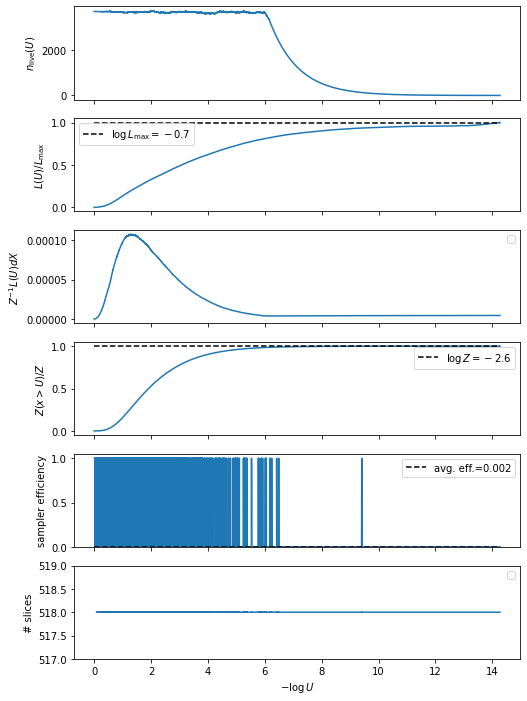

In [12]:
ns.summary(results)
plot_diagnostics(results)

In [13]:
samples = resample(random.PRNGKey(45), results.samples, results.log_dp_mean, S=int(results.ESS), replace=True)

def predict(params):
    params_dict = unravel_func(params)
    logits = model.apply(params_dict, x)
    return jax.nn.sigmoid(logits)[:,0]

predictions = vmap(predict)(samples['params'])

for i in range(len(y)):
    print(f"{i}: {x[i]} -> {y[i]} | pred: {jnp.percentile(predictions[:,i],jnp.asarray([5,50,95]))}")

0: [1. 1. 1. 1. 1. 1. 1.] -> [ True] | pred: [0.00103126 0.49528607 0.99913188]
1: [1. 1. 1. 1. 1. 1. 0.] -> [False] | pred: [6.94662719e-04 5.02862017e-01 9.99380681e-01]
2: [1. 1. 1. 1. 1. 0. 1.] -> [False] | pred: [7.85691118e-04 4.94878175e-01 9.99368675e-01]
3: [1. 1. 1. 1. 1. 0. 0.] -> [ True] | pred: [6.86792134e-04 4.99731533e-01 9.99533161e-01]
4: [1. 1. 1. 1. 0. 1. 1.] -> [False] | pred: [6.81417539e-04 5.03900305e-01 9.99360754e-01]
5: [1. 1. 1. 1. 0. 1. 0.] -> [ True] | pred: [4.72160559e-04 4.93805532e-01 9.99533428e-01]
6: [1. 1. 1. 1. 0. 0. 1.] -> [ True] | pred: [6.48802484e-04 5.10978018e-01 9.99553273e-01]
7: [1. 1. 1. 1. 0. 0. 0.] -> [False] | pred: [4.33210741e-04 4.93750984e-01 9.99656106e-01]
8: [1. 1. 1. 0. 1. 1. 1.] -> [False] | pred: [7.15740475e-04 5.04819062e-01 9.99357916e-01]
9: [1. 1. 1. 0. 1. 1. 0.] -> [ True] | pred: [5.79395071e-04 5.00037639e-01 9.99513933e-01]
10: [1. 1. 1. 0. 1. 0. 1.] -> [ True] | pred: [5.96683114e-04 5.09944024e-01 9.99524203e-01]

97: [0. 0. 1. 1. 1. 1. 0.] -> [False] | pred: [4.48990617e-04 4.93567638e-01 9.99554132e-01]
98: [0. 0. 1. 1. 1. 0. 1.] -> [False] | pred: [4.60263566e-04 5.14459030e-01 9.99657279e-01]
99: [0. 0. 1. 1. 1. 0. 0.] -> [ True] | pred: [3.89843863e-04 5.32885825e-01 9.99732145e-01]
100: [0. 0. 1. 1. 0. 1. 1.] -> [False] | pred: [4.28677446e-04 4.90888066e-01 9.99521777e-01]
101: [0. 0. 1. 1. 0. 1. 0.] -> [ True] | pred: [3.39960660e-04 5.04684709e-01 9.99642692e-01]
102: [0. 0. 1. 1. 0. 0. 1.] -> [ True] | pred: [4.00429976e-04 5.06471736e-01 9.99660524e-01]
103: [0. 0. 1. 1. 0. 0. 0.] -> [False] | pred: [3.22375500e-04 4.94894214e-01 9.99700370e-01]
104: [0. 0. 1. 0. 1. 1. 1.] -> [False] | pred: [4.30650091e-04 4.92940060e-01 9.99574702e-01]
105: [0. 0. 1. 0. 1. 1. 0.] -> [ True] | pred: [3.59254448e-04 4.92263379e-01 9.99644005e-01]
106: [0. 0. 1. 0. 1. 0. 1.] -> [ True] | pred: [4.09616961e-04 5.19829015e-01 9.99723255e-01]
107: [0. 0. 1. 0. 1. 0. 0.] -> [False] | pred: [3.61454359e-04 

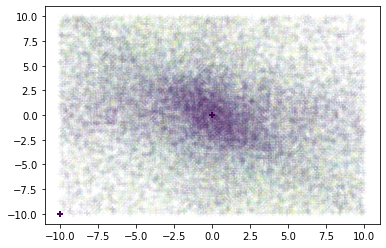

In [14]:
import pylab as plt
plt.scatter(*results.samples['params'][:,-5:-3].T, marker='+',alpha=0.05, c=jnp.exp(results.log_dp_mean))
plt.show()

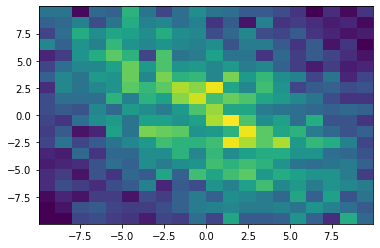

In [15]:
plt.hist2d(*samples['params'][:,-5:-3].T, bins=20)
plt.show()